# Can You Find Voyager 1?
## A Breakthrough Listen Radio SETI Tutorial

[Voyager 1](https://en.wikipedia.org/wiki/Voyager_1) is the most distant human-made object from Earth. Launched by NASA in 1977, it has travelled at fantastic speed (roughly 17,000 m/s), past the outer boundaries of our Solar System and into interstellar space (>13.8 billion miles from the Sun).

Remarkably, 43 years on, Voyager 1 is still sending telemetry data from the depths of interstellar space. This makes it a great systems test for the Breakthrough Listen signal processing pipeline.

In this tutorial, we load, read, and plot some Breakthrough Listen (BL) observations of Voyager 1. The data were taken using the [Robert C. Byrd Greenbank Telescope](https://science.nrao.edu/facilities/gbt) in West Virginia.

### About the data

We used the Greenbank X-band receiver (8.0-11.6 GHz) on December 30, 2015, to observe the known position of Voyager 1. The BL digital signal processing system saves digitized data in a 'raw' format, which we have converted into 'filterbank' format using our gpuspec code, and then into a more efficient '.h5' format. For more information about the `filterbank` format, see the [SIGPROC user guide](http://sigproc.sourceforge.net/sigproc.pdf) or the "Finding ETI" tutorial. 

For the purposes of this tutorial, we will be using the 50 MB Voyager1.single_coarse.fine_res.h5 file consisting of a subset of frequencies (corresponding to a single coarse channel) which should contain the Voyager signal. This datafile is too big to store on GitHub, so we will download it from its location on the [Intro2Astro Google Drive](). As large as it is, this is only 1/64th of the normal size of a single BL datafile!

***

## Step 0: Installing Necessary Software ( `blimpy` and `turboSETI`)

Before we do anything else, we need to download the BL-specific software that you'll be using for this project. **If you already have `blimpy` and `turboSETI` downloaded from another tutorial you can skip this step**

### Downloading `blimpy`

The first package to download is called `blimpy`, which stands for "Breakthrough Listen I/O Methods for Python". The `blimpy` package helps us read, investigate, and plot `filterbank` (.fil) files, which you can think of as data cubes which store *power* values at each *frequency* we recorded over *time*. 

We are going to use the development version of blimpy hosted by the UC Berkeley SETI Center on [GitHub](https://github.com/UCBerkeleySETI/blimpy). Because we're using the dev version instead of the stable, `pip install`able version, we'll install this with git instead of pip. Go to a terminal window and use `cd` to navigate to your Week 7 folder (use `ls` to make sure you're in the right place). Now type `git clone https://github.com/UCBerkeleySETI/blimpy.git` (you can copy-paste the address from here, or the GitHub page using the `Code` button). You should see some messages about the code downloading, and, once it's finished, you should have a new directory called `blimpy` in your Week 7 folder. Use `cd` to navigate into it, and then type `pip install .` to install the code you just downloaded. This will take a minute or less and it should download (among itself, and other packages if necessary) something called `h5py`. `.h5` files are a more efficient way to store the same info as `.fil` files, and BL uses the external `h5py` software to do the writing/reading for this format.

### Downloading `turboSETI`

The second package we'll need to download is called `turboSETI` and is the official BL narrowband signal search pipeline. To break that down, turboSETI looks for very narrow frequency bands (~a few Hz) that contain anomalously high powers throughout an observation. It is even capable of following these signals if they drift off of their original frequency due to relative accelerations between the receiver on Earth and the transmitter out in space (very likely, as radial accelerations are *everywhere* in the universe). Finding these narrow signals would be exciting, because there's no astrophysical phenomenon that we know of that can get to bandwidths smaller than ~kHz (and those are radio masers, which are a very interesting topic in their own right). Not only that, but these very narrow signals are how we communicate to each other via GPS, cell signals, etc. on Earth! 

We are going to use my (Sofia Sheikh's) [personal version](https://github.com/Sofysicist/turbo_seti) of the `turboSETI` code, instead of the official version, because there are some features that I've developed, especially with the plotting in the end, that haven't been integrated into the official repository yet. To do this, we'll follow the same steps as we did for `blimpy`.

Go back to your terminal window and make sure you're in the Week 7 folder (use `ls` to make sure you're in the right place - you'll have to do a `cd ..` if you're still in the `blimpy` subfolder). Now type `git clone https://github.com/Sofysicist/turbo_seti.git` (again, you can copy-paste the address from here, or the GitHub page using the `Code` button). The code should download, and, once it's finished, you should have a new directory called `turbo_seti` in your Week 7 folder. Use `cd` to navigate into it, and then type `pip install .` to install the code. This install should be even quicker than `blimpy`.

Whew! Alright, now we're ready to import those packages, and jump into the analysis!

***

## Let's get started!

Start with our standard command to get plots to show nicely in the notebook:

In [2]:
%matplotlib inline

Now let's import a few useful packages:

- `pylab` for plotting
- the `Waterfall()` class from `blimpy` for reading in the data
- the `seti_event` module from `turbo_seti` for finding Voyager within our dataset
- the `find_event` module from `turbo_seti` for displaying the results of `seti_event`

In [10]:
import pylab as plt
from blimpy import Waterfall
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find

Now, let's define the filename and read in the observation data using `Waterfall()`:

In [4]:
file_path = "VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec.0000.h5"
obs = Waterfall(file_path)

We can get basic info about the file by reading the filterbank header. The `info()` method will print and format this information nicely:

In [5]:
obs.info()


--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :            8421.386717353016 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                          1048576
            nifs :                                1
     rawdatafile : guppi_57650_67573_Voyager1_0002.0000.raw
     source_name :                         Voyager1
         src_dej :                       12:10:58.8
         src_raj :                     17:10:03.984
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2016-09-19T18:46:13.000
    tstart (MJD) :                57

There's a lot of information here, and if you're interested in the specifics, you can check out the [BL data format paper](https://arxiv.org/abs/1906.07391). But here's a quick rundown of the important parameters:

**fch1:** The frequency of the first (maximum) frequency channel in the file (MHz)

**foff:** The frequency increment of the file - also known as the frequency resolution / channel width / bin size (MHz)

**nchans:** The number of frequency channels in the file

**source_name:** The name of the source we were pointed at

**src_dej:** The J2000 declination of the observation

**src_raj:** The J2000 right ascension of the observation

**tsamp:** The sample time / time bin size / time resolution of the file (seconds)

**tstart (MJD):** The start time of the observation, in Modified Julian Date

**Num ints in file:** The number of time bins in the file

The selection info at the bottom kindly tells you the data cube shape and the minimum and maximum frequencies in the observation, derived from the quantities that we just discussed. The data has the shape (16, 1, 1048576), meaning that is has 16 time integrations, and 1048576 channels, over a bandwidth of 2.9 MHz. For the record, that's a lot of channels! The corresponding channel bandwidth is far narrower (Hz) than that required for most astrophysical observations (kHz).

The header and data can also be accessed directly as objects in the `Waterfall()` class using `obs.header` and `obs.data`.

# Finding the Signal

We're going to use the Breakthrough Listen narrowband signal search software `turboSETI` to search for potential "hits" in this file: bright spikes at single frequency bins. Finding a statistically-significant narrowband "hit" is the first step to finding ETI with this method.

<span style="color:red">We know that astrophysical objects will never produce narrowband signals - so why don't we immediately celebrate when we see one in our data?</span> (hint: there are many valid answers)

#*Your answer here!*

***

`turboSETI` can be run on `.h5` or `.fil` files, and luckily our Voyager observation is already an `.h5`. When we perform the search for hits with the `turbo.FindDoppler` function, we will have to specify the minimum signal-to-noise ratio and the maximum drift rate that we'd like in our search. For a more in-depth analysis of these parameters, check out the Finding_ETI notebook. Briefly: because Voyager is not fixed on the surface of Earth, it has a relative motion with respect to the telescope, which causes its apparent frequency to drift. The `max_drift` parameter specifies the maximum drift rate for the search with a unit of Hz/sec. `snr` sets the signal-to-noise ratio threshold for a spike to be considered a hit and added to the output table. The values that have been chosen below are tuned to make the rest of the notebook run smoothly (because in the case of Voyager, we actually know what we're looking for!) but feel free to play with them if you're curious.

This is the most computationally-heavy step. For our small example file, it can still take up to a minute to run the next step - be patient!

If you want to run this cell again for any reason, be sure to *remove the previous output files* - they will not overwrite properly.

In [7]:
file = "VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec.0000.h5"
max_drift_rate = 5 #Hz/s
signal_to_noise = 20

find_seti_event = turbo.FindDoppler(file,
                                    max_drift=max_drift_rate, 
                                    snr=signal_to_noise)
find_seti_event.search()

First thing's first: let's see what the results of the search were! These results were saved in a `.dat` file written to your Week7 folder. We can investigate what's in that file by reading it into a `pandas` dataframe with the `read_dat` function below:

In [11]:
find.read_dat("VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec.0000.dat")

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,Source,MJD,RA,DEC,DELTAT,DELTAF,Hit_ID,status,in_n_ons,RFI_in_range
0,1,-0.392226,30.612128,8419.319368,739933,8419.321411,8419.317332,1,1107,VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec...,VOYAGER1,57650.782094907408,17h10m03.984s,12d10m58.8s,18.253611,-2.793968,,,,
1,2,-0.373093,245.707984,8419.297028,747929,8419.299070,8419.294991,1,1107,VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec...,VOYAGER1,57650.782094907408,17h10m03.984s,12d10m58.8s,18.253611,-2.793968,,,,
2,3,-0.392226,31.220652,8419.274374,756037,8419.276417,8419.272338,1,1107,VOYAGER_guppi_58202_60970_VOYAGER_0060.gpuspec...,VOYAGER1,57650.782094907408,17h10m03.984s,12d10m58.8s,18.253611,-2.793968,,,,


There's a lot of information stored in the rows of this table, but for now just remember the values in the `Freq` column - those values are where we should expect to see something in the following plots.

## Plotting the data

Now let's hop back to `blimpy` for the plotting, so we can visualize the data that produced the events in the table. The `Waterfall()` class provides a `plot_spectrum()` function to plot the data:

extracting integration 0...


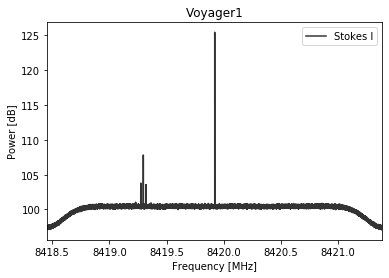

In [11]:
obs.plot_spectrum(logged=True)

<span style="color:red">Do those spikes in the data seem to line up with what was in the `pandas` dataframe above?</span>

#*Your answer here!*

***

What we see in the plot above is the power spectral density (or simply "spectrum") of the data contained in the filterbank file. The `logged=True` tells the plotting script to display the signal on a decibel scale, which makes it easier to see high dynamic range.

Apparent in the plot are the edges of the digital filters (the rolloff on the far left and far right edges), and a big spike in power in the centre. This is known as the "DC bin", and is an artifact caused by the use of the Fast Fourier Transform (FFT) to create spectra.

The code reports that it's `extracting integration 0` because it is only plotting the first time bin of the file - even with only an 18 second integration on the Green Bank Telescope, we can clearly see Voyager's transmission!

Now let's zoom in on the part of the plot where Voyager appears, to get a better sense for what the signal structure looks like. Use the values from your table and the plot above to decide on a reasonable `f_start` and `f_stop` for the zoomed-in plot below. The baseline region around the signal looks pretty flat, so if we exclude the DC bin from our plot, we won't need to use `logged=True` for the next plot.

extracting integration 0...


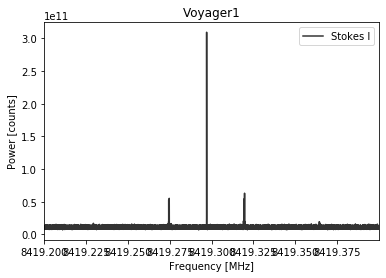

In [14]:
f_start = #your value here!
f_stop = #your value here!
obs.plot_spectrum(f_start=f_start, f_stop=f_stop)

If you see the triple-spike feature, you found the telemetry signal from Voyager 1! What you see is the carrier (center) and two sidebands that carry the data.

We can zoom in on these to see even more features. Choose your frequency limits for each of the three following plots, and play with them to get a good look at the three parts of the signal. You should be able to see some interesting structure in the sidebands.

extracting integration 0...
extracting integration 0...
extracting integration 0...


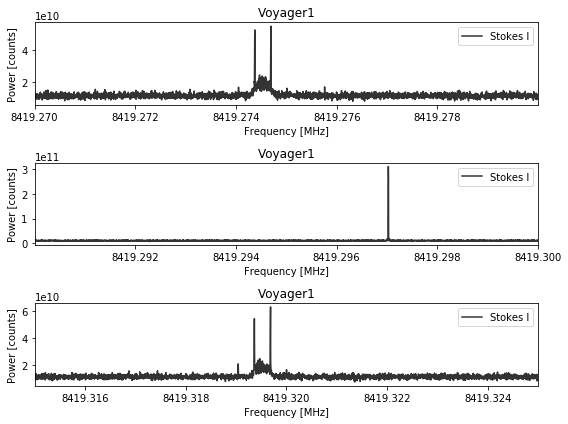

In [15]:
left_start = #your value here! #MHz
left_stop = #your value here! #MHz

center_start = #your value here! #MHz
center_stop = #your value here! #MHz

right_start = #your value here! #MHz
right_stop = #your value here! #MHz

plt.figure(figsize=(8, 6))
plt.subplot(3,1,1)
obs.plot_spectrum(f_start=left_start, f_stop=left_stop) # left sideband
plt.subplot(3,1,2)
obs.plot_spectrum(f_start=center_start, f_stop=center_stop) # carrier
plt.subplot(3,1,3)
obs.plot_spectrum(f_start=right_start, f_stop=right_stop) # right sideband
plt.tight_layout()

In radio telecommunications, a "carrier wave" is an extremely bright, non-information-carrying signal that helps the receiver locate the wide-band but less luminous "sidebands", which are the amplitude-modulated or frequency-modulated regions that actually carry the information (in this case, Voyager's position, velocity, instrument readings etc.).

Finally, let's look at the entire observation instead of just the first 18 seconds. We can see this by plotting what's known as a 'waterfall plot', or dynamic spectrum, which shows the spectrum as a function of time. I recommend that you look at one of the side-bands in the frequency bounds below, because the behaviour is easier to see in the wider signal.

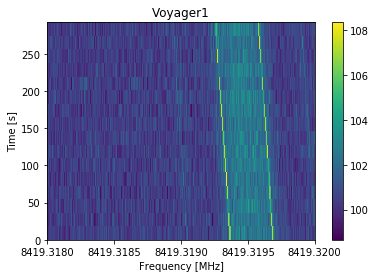

In [16]:
start_f_wat = #your value here! #MHz
stop_f_wat = #your value here! #MHz
obs.plot_waterfall(f_start=start_f_wat, f_stop=stop_f_wat)

In this plot, the two axes are frequency channel and time, and the color corresponds to power level. When NASA communicates with the spacecraft, it needs to take into account the "Doppler drift rate", or the fact that the signal drifts across frequencies over the course of the observation. In this observation, that's mostly due to the fact that the Earth was rotating towards Voyager as we observed! Likewise, when Breakthrough Listen is searching for SETI signals, we need to search across a range of different doppler drift rates to maximize the signal-to-noise of a potential signal, for which we won't know the actual drift rate.

<span style="color:red">How do you know, from just this plot, that the Earth was rotating towards Voyager and not away from it?</span>

*Your answer here!*

***

## Discussion

Let's take a moment to pause and reflect. This faint signal has travelled billions of miles through space, back to us here on Earth. Launching this probe out of the Solar System was an immense feat, and the fact that we can detect it still, 43 years after its launch, is even more impressive.

The signals from probes such as Voyager are very different from the signals we measure from astrophysical objects. In Breakthrough Listen, we use this clear difference between natural and artificial signals in our approach for detecting extraterrestrial signals.

CONGRATULATIONS! You have finished this tutorial :)